# Visualize alpha entmax

This notebook visualizes the learned alphas in `alpha-entmax` model

In [1]:
import os
import re
import sys
import json
import random
random.seed(42)
from typing import Optional, Any
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

package_root = os.path.dirname(os.getcwd())
sys.path.insert(0, package_root)

import torch
torch.manual_seed(42)

import numpy as np
np.random.seed(42)

from sparse_detector.configs import (
    build_dataset_config,
    build_detr_config,
    build_matcher_config,
    load_base_configs,
)
from sparse_detector.models import build_model
from sparse_detector.models.matcher import build_matcher
from sparse_detector.models.utils import describe_model

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
import matplotlib.patches as patches
import seaborn as sns

sns.set(font_scale=1.4)
sns.set_style("whitegrid", {
    "grid.linestyle": 'dashed',
    "axes.edgecolor": '#475569',
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial',
        'Droid Sans',
        'sans-serif'
    ],
})
%matplotlib inline

**Load model**

In [2]:
device = torch.device('cuda')

detr_config_file = "../configs/decoder_alpha_entmax.yml"
base_config = load_base_configs()
detr_config = build_detr_config(detr_config_file, params=None, device=device)
# Important, we'll average the attention's weights across head for PAIBB
detr_config["average_cross_attn_weights"] = True

matcher_config = build_matcher_config(detr_config_file)

resume_from_checkpoint = "../checkpoints/v2_decoder_alpha_entmax/checkpoint_0299.pth"
model, criterion, _ = build_model(**detr_config)
checkpoint = torch.load(resume_from_checkpoint, map_location="cpu")
model.load_state_dict(checkpoint["model"])

model.eval()
model.to(device)
describe_model(model)

Cross-attention activation: alpha_entmax; average attention weights: True
Transformer.reset_parameters()
+-------------+-------------+-----------------+
| Module      |   Trainable |   Non-trainable |
|-------------+-------------+-----------------|
| bbox_embed  |      132612 |               0 |
| query_embed |       25600 |               0 |
| backbone    |    23232512 |          222400 |
| input_proj  |      524544 |               0 |
| transformer |    17364016 |               0 |
| class_embed |       23644 |               0 |
|             |             |                 |
| Total       |    41302928 |          222400 |
+-------------+-------------+-----------------+


**Setup forward hooks**

In [4]:
model.transformer.decoder.layers[0].multihead_attn.get_alpha()

tensor([1.0100, 2.0000, 1.0100, 1.0477, 1.0100, 1.0222, 1.0100, 1.0100],
       device='cuda:0', grad_fn=<ClampBackward1>)

In [5]:
alphas = []
for i in range(6):
    alphas.append(model.transformer.decoder.layers[i].multihead_attn.get_alpha())

**Visualize alphas**

In [7]:
alpha_t = torch.stack(alphas)
alpha_t

tensor([[1.0100, 2.0000, 1.0100, 1.0477, 1.0100, 1.0222, 1.0100, 1.0100],
        [1.0100, 1.1633, 1.1970, 1.2226, 1.1655, 1.0100, 1.0100, 1.0100],
        [1.2137, 1.0100, 1.0301, 1.0100, 1.2614, 1.2301, 1.0100, 1.2485],
        [1.0100, 1.0690, 1.2428, 1.2517, 1.3145, 1.2883, 1.0100, 1.0100],
        [1.2603, 1.3464, 1.2841, 1.0100, 1.0100, 1.3169, 1.0100, 1.1347],
        [1.0100, 1.2042, 1.1361, 1.0100, 1.0100, 1.0100, 1.0409, 1.2598]],
       device='cuda:0', grad_fn=<StackBackward0>)

In [8]:
alpha_t.T

tensor([[1.0100, 1.0100, 1.2137, 1.0100, 1.2603, 1.0100],
        [2.0000, 1.1633, 1.0100, 1.0690, 1.3464, 1.2042],
        [1.0100, 1.1970, 1.0301, 1.2428, 1.2841, 1.1361],
        [1.0477, 1.2226, 1.0100, 1.2517, 1.0100, 1.0100],
        [1.0100, 1.1655, 1.2614, 1.3145, 1.0100, 1.0100],
        [1.0222, 1.0100, 1.2301, 1.2883, 1.3169, 1.0100],
        [1.0100, 1.0100, 1.0100, 1.0100, 1.0100, 1.0409],
        [1.0100, 1.0100, 1.2485, 1.0100, 1.1347, 1.2598]], device='cuda:0',
       grad_fn=<PermuteBackward0>)

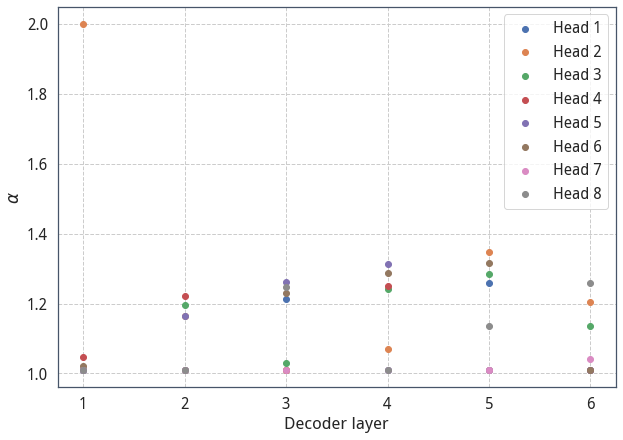

In [9]:
layers, heads = alpha_t.shape

fig, ax = plt.subplots(figsize=(10, 7))

markers = ['o', 'v', 's', 'p', '>', 'h', '*', 'P']
for head in range(heads):
    plt.scatter(np.arange(layers), alpha_t.T[head].detach().cpu(), label=f"Head {head+1}")

ax.set_xlabel("Decoder layer")
ax.set_ylabel(r"$\alpha$")
ax.set_xticks(np.arange(6), np.arange(1, 7))
plt.legend()

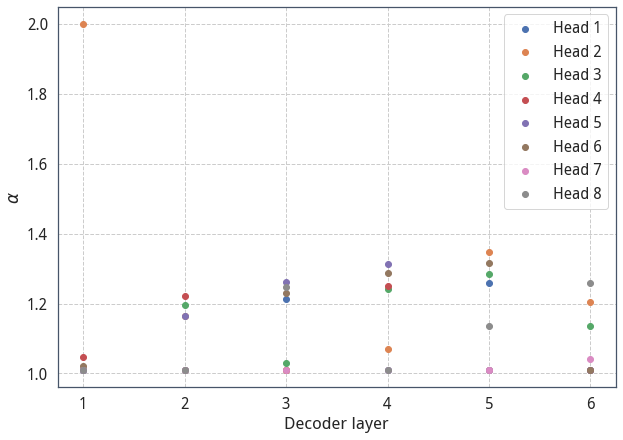

In [12]:
layers, heads = alpha_t.shape

fig, ax = plt.subplots(figsize=(10, 7))

markers = ['o', 'v', 's', 'p', '>', 'h', '*', 'P']
for head in range(heads):
    plt.scatter(np.arange(layers), alpha_t.T[head].detach().cpu(), label=f"Head {head+1}")

ax.set_xlabel("Decoder layer")
ax.set_ylabel(r"$\alpha$")
ax.set_xticks(np.arange(6), np.arange(1, 7))
plt.legend()

fig.savefig("./images/a-entmax_alphas.png", bbox_inches='tight')
fig.savefig("./images/a-entmax_alphas.pdf", bbox_inches='tight')